## Introduction to FAISS (Pinecone/James Briggs course)

In [2]:
import requests
import os

In [1]:
data_url = "https://raw.githubusercontent.com/jamescalam/data/main/sentence_embeddings_15K/"

In [ ]:
os.chdir(os.path.join(os.getcwd()))
os.mkdir('../../data/')
if not os.path.exists('../../data/data_faiss_intro'):
    os.mkdir('../../data/data_faiss_intro')

for i in range(57):
#     if i < 10:
#         i = '0' + str(i)
    res = requests.get(data_url+f"embeddings_{i}.npy")
    with open(f'../../data/data_faiss_intro/embeddings_{i}.npy', 'wb') as fp:
        for chunk in res:
            fp.write(chunk)
    print('.', end='')

In [ ]:
res = requests.get(f"{data_url}sentences.txt")
with open(f"../../data/data_faiss_intro/sentences.txt", 'wb') as fp:
    for chunk in res:
        fp.write(chunk)

In [3]:
import numpy as np

In [4]:
for i  in range(57):
    if i == 0:
        with open(f'../../data/data_faiss_intro/embeddings_{i}.npy', 'rb') as fp:
            sentence_embedding = np.load(fp)
    else:
        with open(f'../../data/data_faiss_intro/embeddings_{i}.npy', 'rb') as fp:
            sentence_embedding = np.append(
                sentence_embedding, 
                np.load(fp), axis=0
            )      

In [5]:
sentence_embedding.shape

(14504, 768)

In [6]:
with open('../../data/data_faiss_intro/sentences.txt', 'r') as fp:
    lines = fp.read().split('\n')

In [7]:
lines[:5]

['A group of four children dancing in a backyard.',
 'The Conference Board said its measure of business confidence, which had fallen to 53 in the first quarter of 2003, improved to 60 in the most recent second quarter.',
 'a person eating a meal, often in a restaurant',
 'When you crossed the line, you violated the constitutional right," said Charles Weisselberg, who teaches law at the University of California, Berkeley.',
 "Ross Garber, Rowland's legal counsel, said the governor would have no comment on the condo deal."]

In [8]:
from sentence_transformers import SentenceTransformer

In [9]:
model = SentenceTransformer('symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.73k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/677 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/356 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [10]:
# model.encode(['Hello wolrd'], device='cuda', show_progress_bar=True)

In [11]:
import faiss

## Index using FlatL2

In [ ]:
#IndexFlatL2 (eulidean distance)
d = sentence_embedding.shape[1]

In [ ]:
index_fl2 = faiss.IndexFlatL2(d) # define index type
res = faiss.StandardGpuResources()  # use a single GPU

# make it into a gpu index
gpu_index_fl2 = faiss.index_cpu_to_gpu(res, 0, index_fl2)


In [ ]:
gpu_index_fl2.is_trained

In [ ]:
gpu_index_fl2.add(sentence_embedding)

In [ ]:
gpu_index_fl2.ntotal

In [ ]:
xq = model.encode(['someone sprints with a football'], device = 'cuda')

In [ ]:
k = 4 # similar vectors number

In [ ]:
%%time
D, I = gpu_index_fl2.search(xq, k)
print(I)

In [ ]:
[f'{i}: {lines[i]}' for i in I[0]]

## Partitioning indexing using IVFFlat

Approximate searching 

In [ ]:
nlist = 50 # number of cells or voronoi poligons

# Flat L2 Index
index = faiss.IndexFlatL2(d)

res = faiss.StandardGpuResources()  # use a single GPU
# make it into a gpu index and takenir
quantizer = faiss.index_cpu_to_gpu(res, 0, index)

gpu_index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist)

In [ ]:
gpu_index_ivf.is_trained

In [ ]:
# we need to train our index
gpu_index_ivf.train(sentence_embedding)

In [ ]:
gpu_index_ivf.is_trained

In [ ]:
gpu_index_ivf.add(sentence_embedding)
gpu_index_ivf.ntotal

In [ ]:
%%time
D, I = gpu_index_ivf.search(xq, k)
print(I)

In [ ]:
[f'{i}: {lines[i]}' for i in I[0]]

In [ ]:
# change nprobe to improve better results but with less speed
gpu_index_ivf.nprobe = 10

In [ ]:
%%time
D, I = gpu_index_ivf.search(xq, k)
print(I)

In [ ]:
[f'{i}: {lines[i]}' for i in I[0]]

## Product quantization index

Faster but with with less precision. 

Split the original vector in n sub-vectors. Run a cluster algorithm for every sub-vector. Search the similar cluster and search the result inside the sub-vector that corresponds the cluster.

In [ ]:
# firs we need to see if we can divide the centroid
# d need to be a multiple of m
d % 8

In [ ]:
nlist = 50 # number of cells

m = 8 # number of centroids in the final vector
bits = 8 # number of bits inside that vector

# quantizer Flat L2 Index
index = faiss.IndexFlatL2(d)

res = faiss.StandardGpuResources()  # use a single GPU
# make it into a gpu index and takenir
quantizer = faiss.index_cpu_to_gpu(res, 0, index)

gpu_index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) # reduce the size using this method

In [ ]:
gpu_index_ivfpq.is_trained

In [ ]:
gpu_index_ivfpq.train(sentence_embedding)

In [ ]:
gpu_index_ivfpq.is_trained

In [ ]:
gpu_index_ivfpq.add(sentence_embedding)
gpu_index_ivfpq.ntotal

In [ ]:
%%time
D, I = gpu_index_ivfpq.search(xq, k)
print(I)

In [ ]:
[f'{i}: {lines[i]}' for i in I[0]]

## Speed improvement with syntethic data

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snsaaaaaaaaaaaaaassssssssssssssssssssssss
from tqdm import tqdm
from datetime import datetime

In [13]:
colors = ['#041BB3', '#E31957', '#12B0A7','#B8255F' ,'#FAD000' ,'#000000']
sns.set_palette(sns.color_palette(colors))
sns.set_theme(font_scale=1.4)

In [14]:
def make_array(nb, d=100):
    return np.random.random((nb, d)).astype('float32')

In [15]:
def test(index, step=1_000, high=1_000_000, k=5, epochs=20):
    timer = np.zeros((epochs, int(high/step)))
    dim = np.zeros((int(high/step)))
    xq = make_array(1)
    for epoch in tqdm(range(epochs)):
        index.reset()
        iter_step = 0
        for i in range(step, high, step):
            wb = make_array(step)
            if not index.is_trained:
                index.train(wb)
            index.add(wb)
            # start timer
            start = datetime.now()
            D,I = index.search(xq, k)
            time_taken = (datetime.now() - start).microseconds
            timer[epoch, iter_step] = time_taken
            dim[iter_step] = i
            iter_step += 1
    timer = np.median(timer, axis=0)
    return dim, timer

In [16]:
d = 100
tests = pd.DataFrame({
    'num_vectors' : [],
    'query_time': [],
    'test': []
})


In [17]:
# Flat L2 Index
index = faiss.IndexFlatL2(d)

In [18]:
res = faiss.StandardGpuResources()  # use a single GPU
# make it into a gpu index
gpu_index = faiss.index_cpu_to_gpu(res, 0, index)

In [19]:
%%time
# test with GPU faiss time
dim, time = test(gpu_index,step=1_000, high=100_000, k=5, epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]

CPU times: user 5.61 s, sys: 122 ms, total: 5.73 s
Wall time: 6.91 s


In [20]:
%%time
# test with CPU faiss 
dim, time = test(index,step=1_000, high=100_000, k=5, epochs=20)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.85it/s]

CPU times: user 10.8 s, sys: 0 ns, total: 10.8 s
Wall time: 10.8 s


In [21]:
%%time
# continuation of the example with GPU (faster) IndexFlat
dim, time = test(gpu_index)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [06:33<00:00, 19.69s/it]

CPU times: user 5min 7s, sys: 3.63 s, total: 5min 11s
Wall time: 6min 33s


In [22]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'FlatL2'
tests = tests.append(df, ignore_index=True)

In [25]:
# IVFFlat

nlist = 50 # number of cells or voronoi poligons
quantizer = faiss.IndexFlatL2(d)
index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist)
gpu_index_ivf =  faiss.index_cpu_to_gpu(res, 0, index_ivf)

In [26]:
gpu_index_ivf.nprobe

1

In [28]:
%%time
dim, time = test(gpu_index_ivf)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.97s/it]

CPU times: user 35.4 s, sys: 3.06 s, total: 38.4 s
Wall time: 39.4 s


In [29]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'IVFFlat'
tests = tests.append(df, ignore_index=True)

In [30]:
# ivf n probe 5
gpu_index_ivf.nprobe = 5

In [31]:
dim, time = test(gpu_index_ivf)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.47s/it]


In [32]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'IVFFlat 5'
tests = tests.append(df, ignore_index=True)

In [33]:
# ivf n probe 10
gpu_index_ivf.nprobe = 10

In [34]:
%%time
dim, time = test(gpu_index_ivf)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:52<00:00,  2.64s/it]

CPU times: user 47.5 s, sys: 3.03 s, total: 50.5 s
Wall time: 52.8 s


In [35]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'IVFFlat 10'
tests = tests.append(df, ignore_index=True)

In [70]:
d%10

0

In [74]:
# IVFPQ
nlist = 50 # number of cells or number of centroids

m = 4 # number of centroids in the final vector or code sizes
bits = 8 # number of bits inside that vector

quantizer = faiss.IndexFlatL2(d)

# co is only for GPU
# co = faiss.GpuClonerOptions()
# co.useFloat16LookupTables = True
# co.useFloat16 = True

index_ivfpq = faiss.IndexIVFPQ(quantizer, d, nlist, m, bits) # reduce the size using this method
gpu_index_ivfpq =  faiss.index_cpu_to_gpu(res, 0, index_ivfpq)

In [75]:
%%time
dim, time = test(gpu_index_ivfpq)

  0%|                                                                                            | 0/20 [00:00<?, ?it/s]WARNING clustering 1000 points to 50 centroids: please provide at least 1950 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
WARNING clustering 1000 points to 256 centroids: please provide at least 9984 training points
100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:53<00:00,  2.67s/it]

CPU times: user 48 s, sys: 8.05 s, total: 56 s
Wall time: 53.3 s


In [76]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'IVFPQ'
tests = tests.append(df, ignore_index=True)

In [77]:
# ivfpq nprobe = 10
gpu_index_ivfpq.nprobe = 10

In [78]:
%%time
dim, time = test(gpu_index_ivfpq)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.46s/it]

CPU times: user 42.4 s, sys: 6.63 s, total: 49.1 s
Wall time: 49.1 s


In [79]:
df = pd.DataFrame({
    'num_vectors': dim.tolist(),
    'query_time': time.tolist()
})
df['test'] = 'IVFPQ 10'
tests = tests.append(df, ignore_index=True)

Text(0, 0.5, 'query time (ms)')

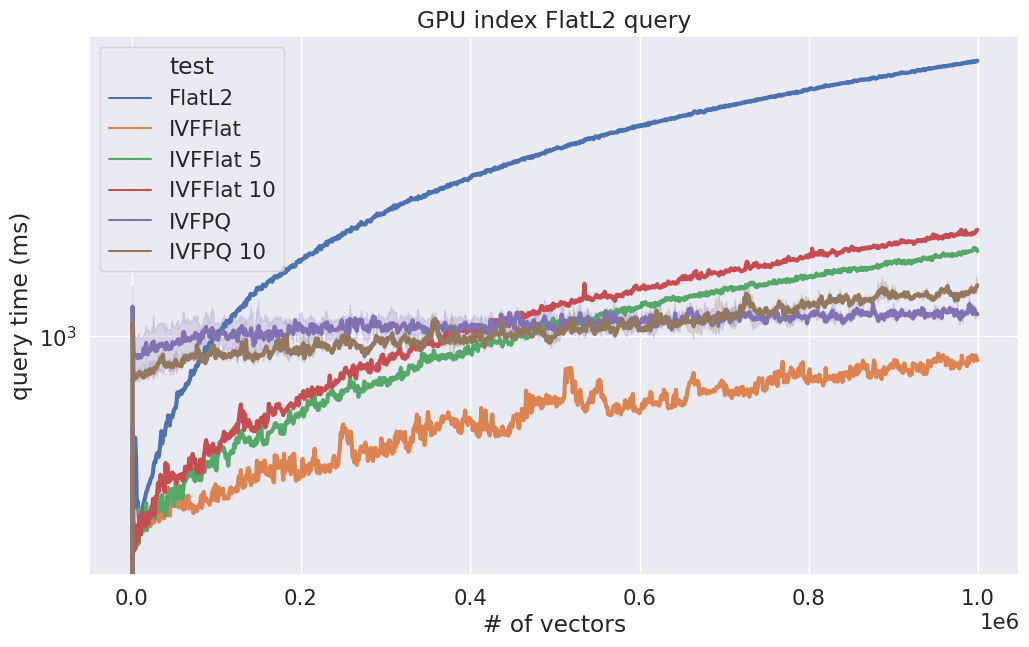

In [80]:
plt.figure(figsize=(12,7))
ax = sns.lineplot(x='num_vectors', y='query_time', 
                  data=tests,
                  hue='test',
                  linewidth = 3)
ax.set_yscale("log")
ax.set_title('GPU index FlatL2 query')
ax.set_xlabel('# of vectors')
ax.set_ylabel('query time (ms)')

## For this test in GPU, IVFFlat configurations are faster than IVFPQ